# Análise de Sentimentos - Books Reviews
Notebook para análise de sentimentos dos reviews utilizando VADER

## Carregar Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from tqdm import tqdm
from collections import Counter

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")

# Configurar pandas para exibir mais colunas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

## Carregar Datasets

In [2]:
# Carregar datasets processados
books_data = pd.read_parquet('../data/processed/books_data_processed.parquet')
books_rating = pd.read_parquet('../data/processed/books_rating_processed.parquet')

print("Datasets carregados:")
print(f"   books_data: {books_data.shape}")
print(f"   books_rating: {books_rating.shape}")

# Verificar estrutura do dataset de ratings
print("\nColunas em books_rating:")
print(books_rating.columns.tolist())

print("\nInfo sobre reviews:")
print(f"   Reviews com texto: {books_rating['text'].notna().sum():,}")
print(f"   Reviews sem texto: {books_rating['text'].isna().sum():,}")
print(f"   Percentual com texto: {(books_rating['text'].notna().sum() / len(books_rating)) * 100:.1f}%")

Datasets carregados:
   books_data: (12922, 15)
   books_rating: (299748, 10)

Colunas em books_rating:
['Id', 'Title', 'Price', 'User_id', 'profileName', 'score', 'time', 'summary', 'text', 'title_norm']

Info sobre reviews:
   Reviews com texto: 299,748
   Reviews sem texto: 0
   Percentual com texto: 100.0%


## Função de Análise de Sentimentos

In [3]:
def analise_de_sentimentos(books_df, frac=None, n=None, random_state=42):
    """
    Análise de sentimentos com VADER
    
    Parâmetros:
        - books_df: DataFrame original
        - frac: proporção da amostra (ex: 0.1 para 10%)
        - n: número absoluto de registros (ex: 1000)
        - random_state: para reprodutibilidade
        
    Retorna:
        - DataFrame com coluna 'sentimento' na amostra analisada
    """
    
    # Seleção da amostra
    if frac:
        df_temp = books_df.sample(frac=frac, random_state=random_state)
    elif n:
        df_temp = books_df.sample(n=n, random_state=random_state)
    else:
        df_temp = books_df.copy()
        
    analyser = SentimentIntensityAnalyzer()
    sent_analysis = []
    compound_scores = []

    for index, row in tqdm(df_temp.iterrows(), total=len(df_temp), desc="Processando reviews"):
        
        texto = str(row['text']).strip()
        
        if not texto:
            sent_analysis.append('n/a')
            compound_scores.append(None)
            continue
            
        try:
            vs = analyser.polarity_scores(texto)
            compound = vs['compound']
            
            if compound >= 0.05:
                label = 'positivo'
            elif compound <= -0.05:
                label = 'negativo'
            else:
                label = 'neutro'
                
        except Exception as e:
            print(f"Erro no índice {index}: {e}")
            label = 'erro'
            compound = None
            
        sent_analysis.append(label)
        compound_scores.append(compound)

    # Atualiza o DataFrame com os resultados
    df_temp = df_temp.copy()
    df_temp['sentimento'] = sent_analysis
    df_temp['compound'] = compound_scores

    return df_temp

## Teste com Amostra

In [4]:
# Teste com amostra de 1000 registros
print("Testando análise de sentimentos com amostra...")
sample_test = analise_de_sentimentos(books_rating, n=1000)

# Verificar resultados
print("\nDistribuição de sentimentos na amostra:")
print(sample_test['sentimento'].value_counts())

Testando análise de sentimentos com amostra...


Processando reviews: 100%|██████████| 1000/1000 [00:03<00:00, 288.32it/s]


Distribuição de sentimentos na amostra:
sentimento
positivo    828
negativo    156
neutro       16
Name: count, dtype: int64


## Análise Completa

In [5]:
# Análise de sentimentos completa
print("Executando análise de sentimentos no dataset completo...")
books_rating_mod = analise_de_sentimentos(books_rating)

print(f"\nDataset final: {books_rating_mod.shape}")
print("\nDistribuição final de sentimentos:")
print(books_rating_mod['sentimento'].value_counts())

Executando análise de sentimentos no dataset completo...


Processando reviews: 100%|██████████| 299748/299748 [13:19<00:00, 374.84it/s]



Dataset final: (299748, 12)

Distribuição final de sentimentos:
sentimento
positivo    248766
negativo     44883
neutro        6099
Name: count, dtype: int64


## Análise dos Resultados

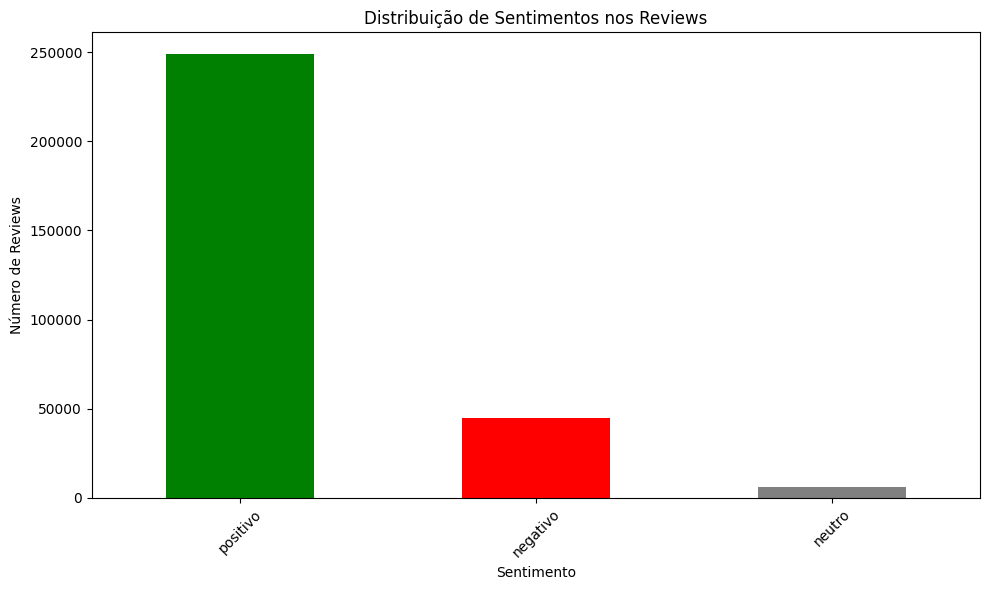


Total de reviews processados: 299,748
   positivo: 248,766 (83.0%)
   negativo: 44,883 (15.0%)
   neutro: 6,099 (2.0%)


In [6]:
# Gráfico de distribuição de sentimentos
plt.figure(figsize=(10, 6))
books_rating_mod['sentimento'].value_counts().plot(kind='bar', color=['green', 'red', 'gray', 'orange'])
plt.title('Distribuição de Sentimentos nos Reviews')
plt.xlabel('Sentimento')
plt.ylabel('Número de Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Estatísticas detalhadas
total_reviews = len(books_rating_mod)
print(f"\nTotal de reviews processados: {total_reviews:,}")

for sentimento, count in books_rating_mod['sentimento'].value_counts().items():
    percentual = (count / total_reviews) * 100
    print(f"   {sentimento}: {count:,} ({percentual:.1f}%)")

## Correlação Rating vs Sentimento

In [8]:
# Analisar correlação entre rating numérico e sentimento
sentimentos_validos = books_rating_mod[books_rating_mod['sentimento'].isin(['positivo', 'neutro', 'negativo'])]

if len(sentimentos_validos) > 0:
    # Correlação entre rating e compound score
    correlacao = sentimentos_validos['score'].corr(sentimentos_validos['compound'])
    print(f"Correlação Rating vs Compound Score: {correlacao:.3f}")
    
    # Tabela cruzada
    print("\nTabela cruzada: Rating vs Sentimento")
    tabela_cruzada = pd.crosstab(sentimentos_validos['score'], sentimentos_validos['sentimento'])
    print(tabela_cruzada)
    
    # Percentuais por rating
    print("\nPercentuais por rating:")
    percentuais = pd.crosstab(sentimentos_validos['score'], sentimentos_validos['sentimento'], normalize='index') * 100
    print(percentuais.round(1))

Correlação Rating vs Compound Score: 0.313

Tabela cruzada: Rating vs Sentimento
sentimento  negativo  neutro  positivo
score                                 
1.0             9337     723      9991
2.0             5112     439      9575
3.0             5507     621     19090
4.0             7781    1004     49973
5.0            17146    3312    160137

Percentuais por rating:
sentimento  negativo  neutro  positivo
score                                 
1.0             46.6     3.6      49.8
2.0             33.8     2.9      63.3
3.0             21.8     2.5      75.7
4.0             13.2     1.7      85.0
5.0              9.5     1.8      88.7


## Salvar Datasets

In [10]:
# Criar diretório se não existir
os.makedirs('../data/modified/', exist_ok=True)

# Salvar em Parquet
books_rating_mod.to_parquet('../data/modified/books_rating_modified.parquet', index=False)
print("Dataset salvo em Parquet: ../data/modified/books_rating_modified.parquet")

Dataset salvo em Parquet: ../data/modified/books_rating_modified.parquet


## Relatório Final

In [11]:
print("RELATÓRIO FINAL - ANÁLISE DE SENTIMENTOS")
print("=" * 50)
print(f"Dataset original: {len(books_rating):,} reviews")
print(f"Dataset processado: {len(books_rating_mod):,} reviews")
print(f"Reviews com texto analisado: {books_rating_mod['sentimento'].notna().sum():,}")

# Distribuição final
print("\nDistribuição de sentimentos:")
for sentimento, count in books_rating_mod['sentimento'].value_counts().items():
    percentual = (count / len(books_rating_mod)) * 100
    print(f"   {sentimento}: {count:,} ({percentual:.1f}%)")

# Estatísticas do compound score
compounds_validos = books_rating_mod['compound'].dropna()
if len(compounds_validos) > 0:
    print("\nEstatísticas do Compound Score:")
    print(f"   Média: {compounds_validos.mean():.3f}")
    print(f"   Mediana: {compounds_validos.median():.3f}")
    print(f"   Desvio padrão: {compounds_validos.std():.3f}")

print("\nArquivo salvo:")
print("   ../data/modified/books_rating_modified.parquet")

RELATÓRIO FINAL - ANÁLISE DE SENTIMENTOS
Dataset original: 299,748 reviews
Dataset processado: 299,748 reviews
Reviews com texto analisado: 299,748

Distribuição de sentimentos:
   positivo: 248,766 (83.0%)
   negativo: 44,883 (15.0%)
   neutro: 6,099 (2.0%)

Estatísticas do Compound Score:
   Média: 0.584
   Mediana: 0.859
   Desvio padrão: 0.569

Arquivo salvo:
   ../data/modified/books_rating_modified.parquet
